## import all

In [1]:
import os
import glob
from natsort import natsorted
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import AnnotationBbox
import matplotlib.patches as patches
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from scipy.stats import pearsonr
import random
import matplotlib
import re

In [2]:
def loadmat_data(filename):
    file = loadmat(filename)
    name = list(file.keys())
    data = file[name[3]]
    return data

In [3]:
def get_specified_1D_item(all_results, item):

    all_value = []
    for i in range(len(all_results)):
        temp = all_results[i][item]
        all_value.append(temp)
    return all_value

In [4]:
def CV_spilt_dataset(sample_numbers, class_num, k):
    indices = np.zeros(sample_numbers)
    for i in range(class_num):
        j = np.arange(class_num*i, class_num*(i+1), 1)
        random_numbers = np.random.permutation(class_num)
        replaced_index = random_numbers >= k
        random_numbers[replaced_index] = np.random.randint(0, k-1, 2)
        indices[j] = random_numbers
    return indices

In [5]:
MonkeyA_path = '/MA/Analysis'
MonkeyB_path = '/MB_CC/Analysis'
MonkeyC_path = '/MC_CC/Analysis'
MonkeyD_path = '/MD/Analysis'

In [6]:
ori = np.arange(-45, 121, 15)
neg_ori_index = np.where(ori < 0)
ori[neg_ori_index] += 180
sf = np.array([0.25, 0.5, 1, 2, 4, 8])
sz = np.array([1, 2, 3])
osiNum = len(sf) * len(sz)  # 18
oln = len(ori)

In [7]:
the_specific_group = 11
the_group = 11

In [268]:
def Regress_10_cv(X_response_non_ori, Y, class_num, model):
    k = 10
    indices = CV_spilt_dataset(X_response_non_ori.shape[0], class_num, k)
    r_out = np.zeros(k)
    p_out = np.zeros(k)
    Mae = np.zeros(k)
    Y_predicted_all = np.array([])
    Y_test_all = np.array([])
    for i in range(k):
        test = (indices == i)
        train = ~test
        X_train = X_response_non_ori[train, :]
        Y_train = Y[train]
        X_test = X_response_non_ori[test, :]
        Y_test = Y[test]
        scaler = StandardScaler()
        X_train_z = scaler.fit_transform(X_train)
        X_test_z = scaler.fit_transform(X_test)
        
        if model == 'LR': 
            reg = LinearRegression()
        if model == 'SVR':
            reg = SVR(kernel='rbf', C=20, gamma='auto')
        if model == 'PLSR':
            reg = PLSRegression(n_components=10)
        if model == 'RFR':
            reg = RandomForestRegressor(n_estimators=100, random_state=0)
        if model == 'Ridge':
            reg = RidgeCV(alphas=[0.1,0.3,0.5,0.7,1])
        if model == 'LASSO':
            Lambdas = np.logspace(-5, 2, 200)
            lasso_cv = LassoCV(alphas=Lambdas, normalize=True, cv=10, max_iter=10000)
            lasso_cv.fit(X_train_z, Y_train)

            lasso_best_alpha = lasso_cv.alpha_  # 0.06294988990221888

            reg = Lasso(alpha=lasso_best_alpha, normalize=True, max_iter=1000)
        if model == 'XGBR':
            reg = XGBRegressor(
                n_estimators=100,
                max_depth=7,
                eta=0.1,
                subsample=0.7,
                colsample_bytree=0.8
            )
                    
        reg.fit(X_train_z, Y_train)
        Y_predicted = np.squeeze(reg.predict(X_test_z))
        r_out[i], p_out[i] = pearsonr(Y_test, Y_predicted)
        Mae[i] = np.mean(abs(Y_test-Y_predicted))
        Y_predicted_all = np.hstack([Y_predicted_all,Y_predicted])
        Y_test_all = np.hstack([Y_test_all, Y_test])
    # r_mean = np.mean(r_out)
    r_mean, p = pearsonr(Y_test_all, Y_predicted_all)
    MAE = np.mean(Mae)
    return r_mean, MAE, Y_predicted_all, Y_test_all

In [8]:
panel_label_size = 12
label_size = 8
tick_size = 6
legend_size = 6

the_specific_group = 11
# monkey_palette = ["#8B9593", "#C66E42", "#8A79BE"]
monkey_palette = ["#9FA7A5", "#3F7AC2", "#8A79BE", "#FE9053"]
ori_color = '#E22B1C'
non_ori_color = '#3161B2'
neuron_color=[ori_color, non_ori_color]
spatial_size = np.array([1,2,3])
spatial_frequency = np.array([0.25,0.5,1,2,4,8])

original_rcParams = dict(mpl.rcParams)
fig_height = 1.6

In [9]:
custom_order = ['LR', 'Ridge', 'SVR', 'RFR', 'XGBR', 'LASSO', 'PLSR']
methods_num = len(custom_order)


## Monkey A

### r

In [39]:
Monkey_path = 'val_results/MA/'

In [40]:
data_path = os.path.join(MonkeyA_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
r_matrix_PLSR = loadmat_data(data_path).T
r_PLSR_the_specific_group = r_matrix_PLSR[the_specific_group, :]
r_all_methods = r_PLSR_the_specific_group
print(np.mean(r_PLSR_the_specific_group))
methods_name = ['PLSR'] * len(r_PLSR_the_specific_group)
x_label_name = ['PLSR']

r_df = pd.DataFrame(columns=['methods', 'r'])   # Empty DataFrame
pattern = r'r_matrix_(\w+)\.npy'
r_filelist = natsorted(glob.glob(Monkey_path+ 'r*.npy'))
for i,filepath in enumerate(r_filelist):
    r_matrix = np.load(filepath)
    r_the_specific_group = np.squeeze(r_matrix[the_specific_group, :])
    r_all_methods = np.hstack([r_all_methods, r_the_specific_group])
    filename = os.path.basename(filepath)
   
    match = re.search(pattern, filename)
    extracted_string = match.group(1)
    methods_string = [extracted_string] * len(r_the_specific_group)
    methods_name.extend(methods_string)
    x_label_name.extend([extracted_string])
    print(f'method={[extracted_string]}, r={np.mean(r_the_specific_group)}')
    
r_df['methods'] = methods_name
r_df['r'] = r_all_methods
    

0.8421664099749828
method=['LASSO'], r=0.7564250263928824
method=['LR'], r=0.5528994249389364
method=['RFR'], r=0.7367485278150011
method=['Ridge'], r=0.7739673636555834
method=['SVR'], r=0.8103304005959836
method=['XGBR'], r=0.7686324331112158


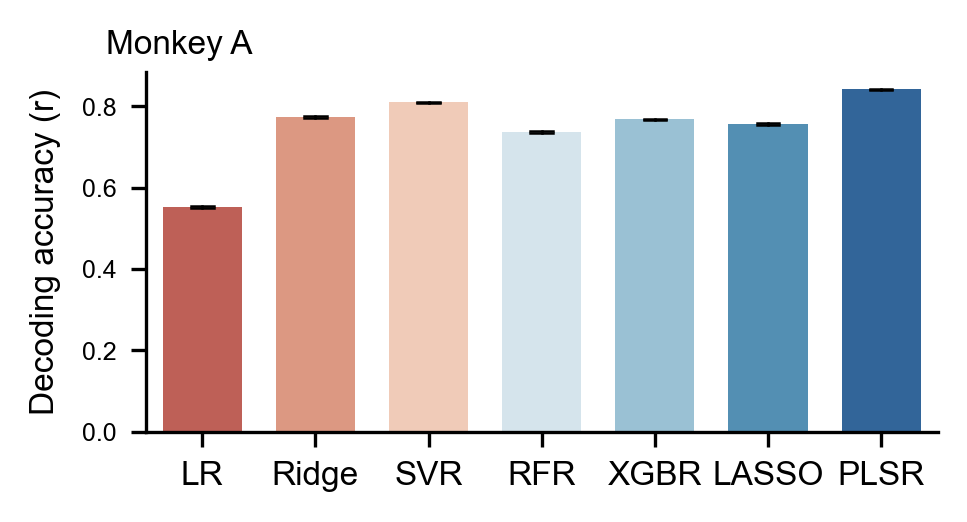

In [41]:
fig = plt.figure(figsize=(3.3,fig_height),facecolor='w', frameon=True, dpi=300) 
plt.style.use('seaborn-muted')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
ax = sns.barplot(x='methods', y='r', data=r_df, order=custom_order, width=0.7,
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci',95), capsize=.2, errwidth=0.6, errcolor='black')


# ax.set_xlabel(r'Monkey', fontsize=label_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding accuracy (r)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, methods_num, 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(custom_order, rotation=0)

# y_label = np.arange(0.96, 1, 0.05)
# y_label = np.round(y_label, 2)
# ax.set_yticks(y_label) 
# ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.05, 1.05, 'Monkey A', transform=ax.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.15, bottom=0.15, right=0.95, top=0.9) 
plt.savefig('./Results_0720/supplementary/FigS4_A_r.pdf', format='pdf', dpi=300)
# plt.savefig('./Results_0720/supplementary/FigS4_A_r.pdf', format='pdf', dpi=300)

### MAE

In [42]:
data_path = os.path.join(MonkeyA_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/MAE_mean_rounds_all_groups_non_ori.mat')
MAE_matrix_PLSR = loadmat_data(data_path).T
MAE_PLSR_the_specific_group = MAE_matrix_PLSR[the_specific_group, :]
MAE_all_methods = MAE_PLSR_the_specific_group
methods_name = ['PLSR'] * len(MAE_PLSR_the_specific_group)
x_label_name = ['PLSR']

MAE_df = pd.DataFrame(columns=['methods', 'MAE'])   # Empty DataFrame
pattern = r'MAE_matrix_(\w+)\.npy'
MAE_filelist = natsorted(glob.glob(Monkey_path+ 'MAE*.npy'))
for i,filepath in enumerate(MAE_filelist):
    MAE_matrix = np.load(filepath)
    MAE_the_specific_group = np.squeeze(MAE_matrix[the_specific_group, :])
    MAE_all_methods = np.hstack([MAE_all_methods, MAE_the_specific_group])
    filename = os.path.basename(filepath)
   
    match = re.search(pattern, filename)
    extracted_string = match.group(1)
    methods_string = [extracted_string] * len(MAE_the_specific_group)
    methods_name.extend(methods_string)
    x_label_name.extend([extracted_string])
    
MAE_df['methods'] = methods_name
MAE_df['MAE'] = MAE_all_methods

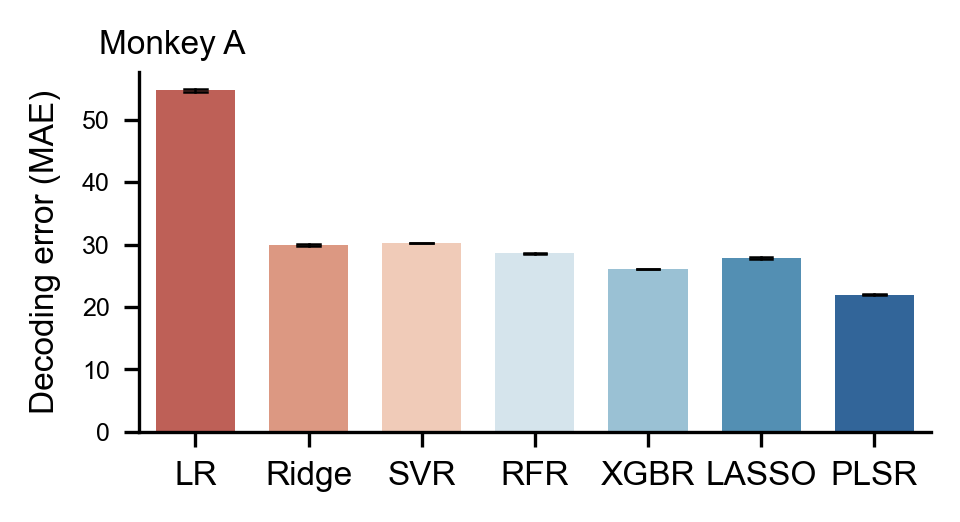

In [43]:
fig = plt.figure(figsize=(3.3,fig_height),facecolor='w', frameon=True, dpi=300) 
plt.style.use('seaborn-muted')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'


custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
ax = sns.barplot(x='methods', y='MAE', data=MAE_df, order=custom_order, width=0.7,
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci',95), capsize=.2, errwidth=0.6, errcolor='black')
# ax = sns.barplot(x='Monkey', y='r', data=r_mean_rounds_df,
#                  estimator=np.mean, color='white', edgecolor='black', linewidth=0.8, 
#                  ci=95, capsize=0.2, errwidth=0.5, errcolor='black')
# ax.set_ylim(0.8,0.9)


# ax.set_xlabel(r'Monkey', fontsize=label_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding error (MAE)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, methods_num, 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(custom_order, rotation=0)

# y_label = np.arange(0.96, 1, 0.05)
# y_label = np.round(y_label, 2)
# ax.set_yticks(y_label) 
# ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.05, 1.05, 'Monkey A', transform=ax.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.15, bottom=0.15, right=0.95, top=0.9)  
# plt.savefig('./Results_0720/supplementary/FigS4_A_MAE.pdf', format='pdf', dpi=300)
plt.savefig('./Results_0720/supplementary/FigS4_A_MAE.pdf', format='pdf', dpi=300)

## Monkey B(MB_CC)

In [44]:
Monkey_path = 'val_results/MB_CC/'

### r

In [45]:
data_path = os.path.join(MonkeyB_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
r_matrix_PLSR = loadmat_data(data_path).T
r_PLSR_the_specific_group = r_matrix_PLSR[the_specific_group, :]
r_all_methods = r_PLSR_the_specific_group
print(np.mean(r_PLSR_the_specific_group))
methods_name = ['PLSR'] * len(r_PLSR_the_specific_group)
x_label_name = ['PLSR']

r_df = pd.DataFrame(columns=['methods', 'r'])   # Empty DataFrame
pattern = r'r_matrix_(\w+)\.npy'
r_filelist = natsorted(glob.glob(Monkey_path+ 'r*.npy'))
for i,filepath in enumerate(r_filelist):
    r_matrix = np.load(filepath)
    r_the_specific_group = np.squeeze(r_matrix[the_specific_group, :])
    r_all_methods = np.hstack([r_all_methods, r_the_specific_group])
    filename = os.path.basename(filepath)
   
    match = re.search(pattern, filename)
    extracted_string = match.group(1)
    methods_string = [extracted_string] * len(r_the_specific_group)
    methods_name.extend(methods_string)
    x_label_name.extend([extracted_string])
    print(f'method={[extracted_string]}, r={np.mean(r_the_specific_group)}')
    
r_df['methods'] = methods_name
r_df['r'] = r_all_methods
    

0.9231880394538111
method=['LASSO'], r=0.808284542434018
method=['LR'], r=0.9111585865178077
method=['RFR'], r=0.8024948202105379
method=['Ridge'], r=0.9116498705904584
method=['SVR'], r=0.8511598510752533
method=['XGBR'], r=0.7849324219316208


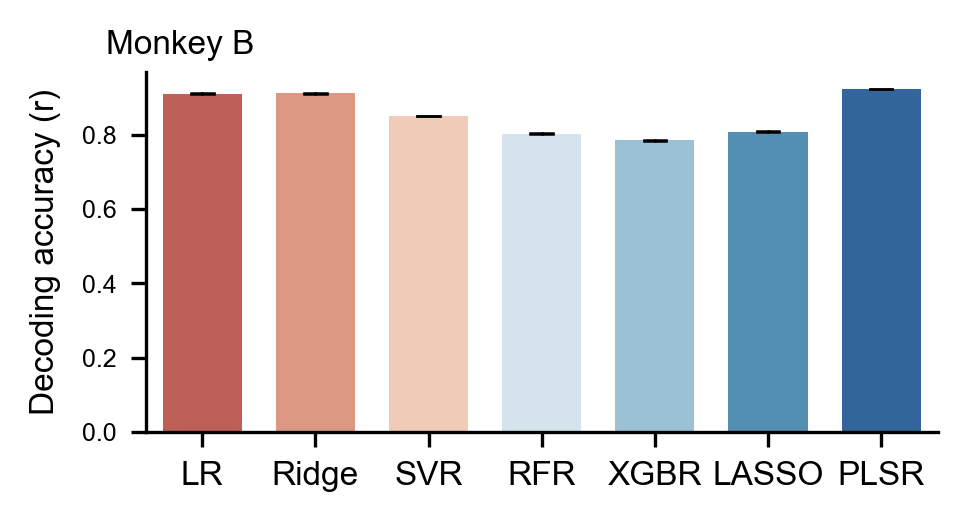

In [46]:
fig = plt.figure(figsize=(3.3,fig_height),facecolor='w', frameon=True, dpi=300) 
plt.style.use('seaborn-muted')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
ax = sns.barplot(x='methods', y='r', data=r_df, order=custom_order, width=0.7,
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci',95), capsize=.2, errwidth=0.6, errcolor='black')



# ax.set_xlabel(r'Monkey', fontsize=label_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding accuracy (r)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, methods_num, 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(custom_order, rotation=0)

# y_label = np.arange(0.96, 1, 0.05)
# y_label = np.round(y_label, 2)
# ax.set_yticks(y_label) 
# ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.05, 1.05, 'Monkey B', transform=ax.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.15, bottom=0.15, right=0.95, top=0.9) 
# plt.savefig('./Results_0720/supplementary/FigS4_B_r.pdf', format='pdf', dpi=300)
plt.savefig('./Results_0720/supplementary/FigS4_B_r.pdf', format='pdf', dpi=300)

### MAE

In [47]:
data_path = os.path.join(MonkeyB_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/MAE_mean_rounds_all_groups_non_ori.mat')
MAE_matrix_PLSR = loadmat_data(data_path).T
MAE_PLSR_the_specific_group = MAE_matrix_PLSR[the_specific_group, :]
MAE_all_methods = MAE_PLSR_the_specific_group
methods_name = ['PLSR'] * len(MAE_PLSR_the_specific_group)
x_label_name = ['PLSR']

MAE_df = pd.DataFrame(columns=['methods', 'MAE'])   # Empty DataFrame
pattern = r'MAE_matrix_(\w+)\.npy'
MAE_filelist = natsorted(glob.glob(Monkey_path+ 'MAE*.npy'))
for i,filepath in enumerate(MAE_filelist):
    MAE_matrix = np.load(filepath)
    MAE_the_specific_group = np.squeeze(MAE_matrix[the_specific_group, :])
    MAE_all_methods = np.hstack([MAE_all_methods, MAE_the_specific_group])
    filename = os.path.basename(filepath)
   
    match = re.search(pattern, filename)
    extracted_string = match.group(1)
    methods_string = [extracted_string] * len(MAE_the_specific_group)
    methods_name.extend(methods_string)
    x_label_name.extend([extracted_string])
    
MAE_df['methods'] = methods_name
MAE_df['MAE'] = MAE_all_methods

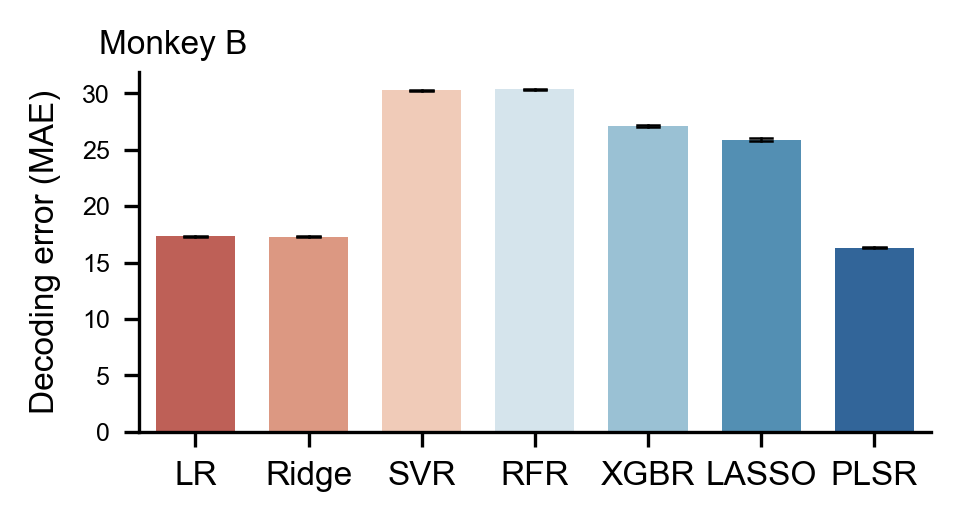

In [48]:
fig = plt.figure(figsize=(3.3,fig_height),facecolor='w', frameon=True, dpi=300) 
plt.style.use('seaborn-muted')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'


custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
ax = sns.barplot(x='methods', y='MAE', data=MAE_df, order=custom_order, width=0.7,
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci',95), capsize=.2, errwidth=0.6, errcolor='black')
# ax = sns.barplot(x='Monkey', y='r', data=r_mean_rounds_df,
#                  estimator=np.mean, color='white', edgecolor='black', linewidth=0.8, 
#                  ci=95, capsize=0.2, errwidth=0.5, errcolor='black')
# ax.set_ylim(0,1)


# ax.set_xlabel(r'Monkey', fontsize=label_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding error (MAE)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, methods_num, 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(custom_order, rotation=0)

# y_label = np.arange(0, 1, 0.1)
# y_label = np.round(y_label, 2)
# ax.set_yticks(y_label) 
# ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.05, 1.05, 'Monkey B', transform=ax.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.15, bottom=0.15, right=0.95, top=0.9) 
plt.savefig('./Results_0720/supplementary/FigS4_B_MAE.pdf', format='pdf', dpi=300)

## Monkey C(MC_CC)

In [25]:
Monkey_path = './val_results/MC_CC/'

### r

In [26]:
data_path = os.path.join(MonkeyC_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
r_matrix_PLSR = loadmat_data(data_path).T
r_PLSR_the_specific_group = r_matrix_PLSR[the_specific_group, :]
r_all_methods = r_PLSR_the_specific_group
print(np.mean(r_PLSR_the_specific_group))
methods_name = ['PLSR'] * len(r_PLSR_the_specific_group)
x_label_name = ['PLSR']

r_df = pd.DataFrame(columns=['methods', 'r'])   # Empty DataFrame
pattern = r'r_matrix_(\w+)\.npy'
r_filelist = natsorted(glob.glob(Monkey_path+ 'r*.npy'))
for i,filepath in enumerate(r_filelist):
    r_matrix = np.load(filepath)
    r_the_specific_group = np.squeeze(r_matrix[the_specific_group, :])
    r_all_methods = np.hstack([r_all_methods, r_the_specific_group])
    filename = os.path.basename(filepath)
   
    match = re.search(pattern, filename)
    extracted_string = match.group(1)
    methods_string = [extracted_string] * len(r_the_specific_group)
    methods_name.extend(methods_string)
    x_label_name.extend([extracted_string])
    print(f'method={[extracted_string]}, r={np.mean(r_the_specific_group)}')
    
r_df['methods'] = methods_name
r_df['r'] = r_all_methods
    

0.9127595478127601
method=['LASSO'], r=0.889960205433478
method=['LR'], r=0.8791188851137236
method=['RFR'], r=0.7398690902174623
method=['Ridge'], r=0.8823862475033861
method=['SVR'], r=0.8604191215634173
method=['XGBR'], r=0.7903246681564658


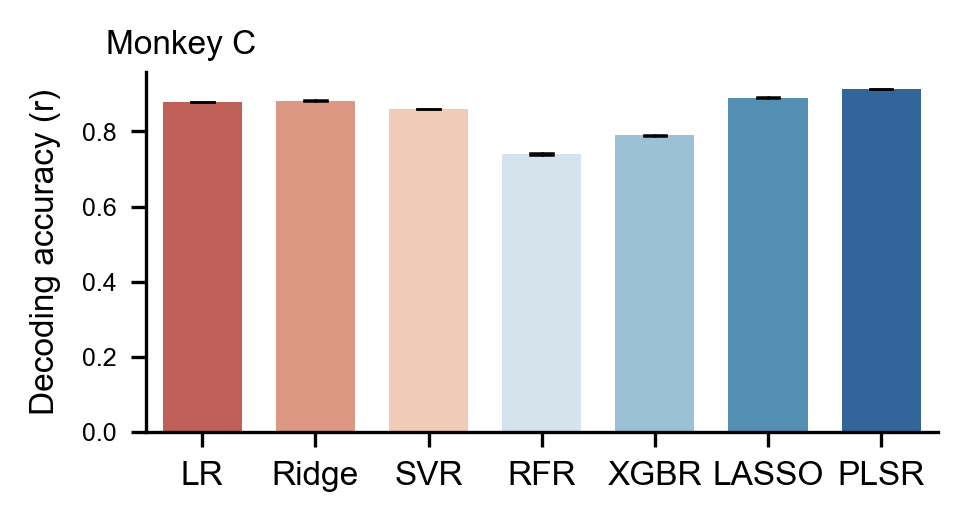

In [27]:
fig = plt.figure(figsize=(3.3,fig_height),facecolor='w', frameon=True, dpi=300) 
plt.style.use('seaborn-muted')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
ax = sns.barplot(x='methods', y='r', data=r_df, order=custom_order, width=0.7,
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci',95), capsize=.2, errwidth=0.6, errcolor='black')



# ax.set_xlabel(r'Monkey', fontsize=label_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding accuracy (r)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, methods_num, 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(custom_order, rotation=0)

# y_label = np.arange(0.96, 1, 0.05)
# y_label = np.round(y_label, 2)
# ax.set_yticks(y_label) 
# ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.05, 1.05, 'Monkey C', transform=ax.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.15, bottom=0.15, right=0.95, top=0.9)  
# plt.savefig('./Results_0720/supplementary/FigS4_C_r.pdf', format='pdf', dpi=300)
plt.savefig('./Results_0720/supplementary/FigS4_C_r.pdf', format='pdf', dpi=300)

### MAE

In [30]:
data_path = os.path.join(MonkeyC_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/MAE_mean_rounds_all_groups_non_ori.mat')
MAE_matrix_PLSR = loadmat_data(data_path).T
MAE_PLSR_the_specific_group = MAE_matrix_PLSR[the_specific_group, :]
MAE_all_methods = MAE_PLSR_the_specific_group
methods_name = ['PLSR'] * len(MAE_PLSR_the_specific_group)
x_label_name = ['PLSR']

MAE_df = pd.DataFrame(columns=['methods', 'MAE'])   # Empty DataFrame
pattern = r'MAE_matrix_(\w+)\.npy'
MAE_filelist = natsorted(glob.glob(Monkey_path+ 'MAE*.npy'))
for i,filepath in enumerate(MAE_filelist):
    MAE_matrix = np.load(filepath)
    MAE_the_specific_group = np.squeeze(MAE_matrix[the_specific_group, :])
    MAE_all_methods = np.hstack([MAE_all_methods, MAE_the_specific_group])
    filename = os.path.basename(filepath)
   
    match = re.search(pattern, filename)
    extracted_string = match.group(1)
    methods_string = [extracted_string] * len(MAE_the_specific_group)
    methods_name.extend(methods_string)
    x_label_name.extend([extracted_string])
    
MAE_df['methods'] = methods_name
MAE_df['MAE'] = MAE_all_methods

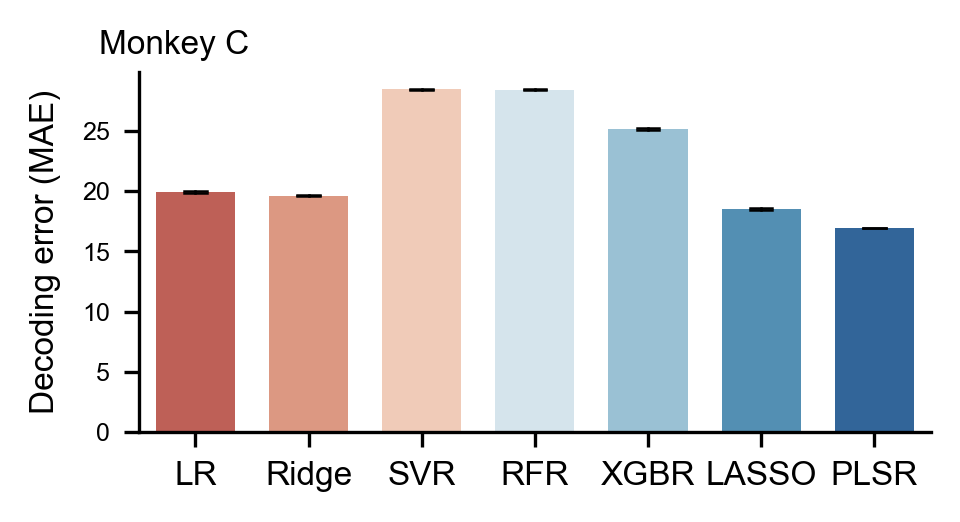

In [31]:
fig = plt.figure(figsize=(3.3,fig_height),facecolor='w', frameon=True, dpi=300) 
plt.style.use('seaborn-muted')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'


custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
ax = sns.barplot(x='methods', y='MAE', data=MAE_df, order=custom_order, width=0.7,
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci',95), capsize=.2, errwidth=0.6, errcolor='black')
# ax = sns.barplot(x='Monkey', y='r', data=r_mean_rounds_df,
#                  estimator=np.mean, color='white', edgecolor='black', linewidth=0.8, 
#                  ci=95, capsize=0.2, errwidth=0.5, errcolor='black')
# ax.set_ylim(0.8,0.9)


# ax.set_xlabel(r'Monkey', fontsize=label_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding error (MAE)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, methods_num, 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(custom_order, rotation=0)

# y_label = np.arange(0.96, 1, 0.05)
# y_label = np.round(y_label, 2)
# ax.set_yticks(y_label) 
# ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.05, 1.05, 'Monkey C', transform=ax.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.15, bottom=0.15, right=0.95, top=0.9) 
plt.savefig('./Results_0720/supplementary/FigS4_C_MAE.pdf', format='pdf', dpi=300)

## Monkey D

In [32]:
Monkey_path = './val_results/MD/'

r

In [33]:
data_path = os.path.join(MonkeyC_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/r_mean_rounds_all_groups_non_ori.mat')
r_matrix_PLSR = loadmat_data(data_path).T
r_PLSR_the_specific_group = r_matrix_PLSR[the_specific_group, :]
r_all_methods = r_PLSR_the_specific_group
print(np.mean(r_PLSR_the_specific_group))
methods_name = ['PLSR'] * len(r_PLSR_the_specific_group)
x_label_name = ['PLSR']

r_df = pd.DataFrame(columns=['methods', 'r'])   # Empty DataFrame
pattern = r'r_matrix_(\w+)\.npy'
r_filelist = natsorted(glob.glob(Monkey_path+ 'r*.npy'))
for i,filepath in enumerate(r_filelist):
    r_matrix = np.load(filepath)
    r_the_specific_group = np.squeeze(r_matrix[the_specific_group, :])
    r_all_methods = np.hstack([r_all_methods, r_the_specific_group])
    filename = os.path.basename(filepath)
   
    match = re.search(pattern, filename)
    extracted_string = match.group(1)
    methods_string = [extracted_string] * len(r_the_specific_group)
    methods_name.extend(methods_string)
    x_label_name.extend([extracted_string])
    print(f'method={[extracted_string]}, r={np.mean(r_the_specific_group)}')
    
r_df['methods'] = methods_name
r_df['r'] = r_all_methods
    

0.9127595478127601
method=['LASSO'], r=0.7002770702079711
method=['LR'], r=0.19633368949713684
method=['RFR'], r=0.7318654163635181
method=['Ridge'], r=0.6238403660916504
method=['SVR'], r=0.8121389582258262
method=['XGBR'], r=0.7362133341980555


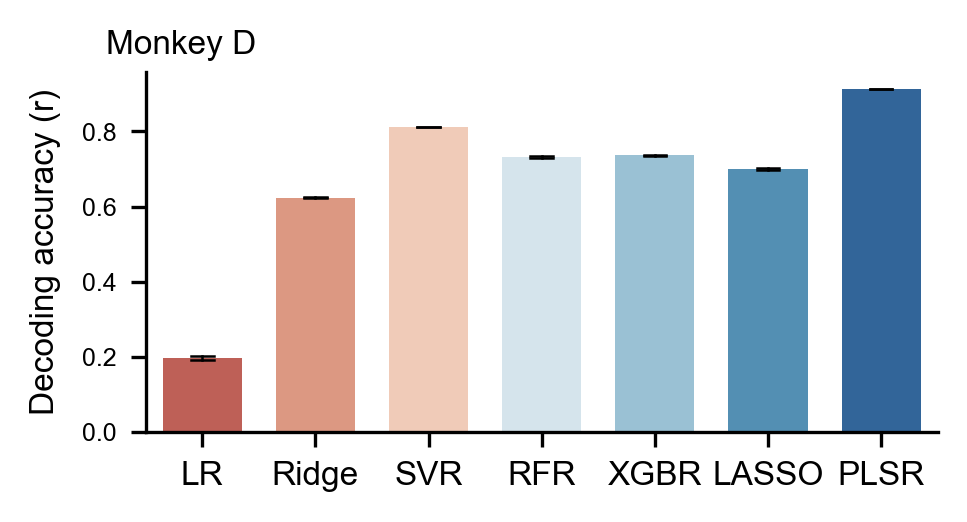

In [34]:
fig = plt.figure(figsize=(3.3,fig_height),facecolor='w', frameon=True, dpi=300) 
plt.style.use('seaborn-muted')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'

custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
ax = sns.barplot(x='methods', y='r', data=r_df, order=custom_order, width=0.7,
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci',95), capsize=.2, errwidth=0.6, errcolor='black')



# ax.set_xlabel(r'Monkey', fontsize=label_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding accuracy (r)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, methods_num, 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(custom_order, rotation=0)

# y_label = np.arange(0.96, 1, 0.05)
# y_label = np.round(y_label, 2)
# ax.set_yticks(y_label) 
# ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.05, 1.05, 'Monkey D', transform=ax.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.15, bottom=0.15, right=0.95, top=0.9)  
plt.savefig('./Results_0720/supplementary/FigS4_D_r.pdf', format='pdf', dpi=300)

MAE

In [35]:
data_path = os.path.join(MonkeyC_path, 'results3_pre_all_unchange_cell/non_ori_cell_rounds_val/MAE_mean_rounds_all_groups_non_ori.mat')
MAE_matrix_PLSR = loadmat_data(data_path).T
MAE_PLSR_the_specific_group = MAE_matrix_PLSR[the_specific_group, :]
MAE_all_methods = MAE_PLSR_the_specific_group
methods_name = ['PLSR'] * len(MAE_PLSR_the_specific_group)
x_label_name = ['PLSR']

MAE_df = pd.DataFrame(columns=['methods', 'MAE'])   # Empty DataFrame
pattern = r'MAE_matrix_(\w+)\.npy'
MAE_filelist = natsorted(glob.glob(Monkey_path+ 'MAE*.npy'))
for i,filepath in enumerate(MAE_filelist):
    MAE_matrix = np.load(filepath)
    MAE_the_specific_group = np.squeeze(MAE_matrix[the_specific_group, :])
    MAE_all_methods = np.hstack([MAE_all_methods, MAE_the_specific_group])
    filename = os.path.basename(filepath)
   
    match = re.search(pattern, filename)
    extracted_string = match.group(1)
    methods_string = [extracted_string] * len(MAE_the_specific_group)
    methods_name.extend(methods_string)
    x_label_name.extend([extracted_string])
    
MAE_df['methods'] = methods_name
MAE_df['MAE'] = MAE_all_methods

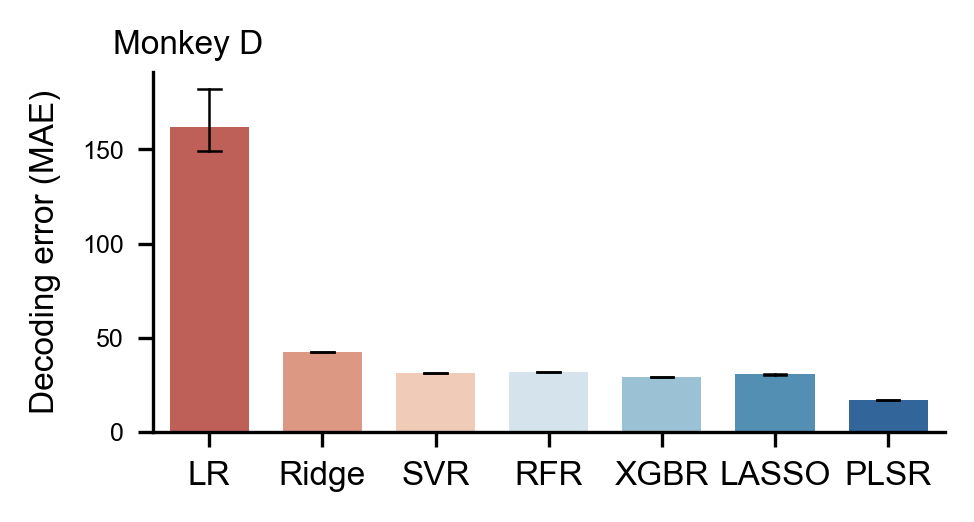

In [36]:
fig = plt.figure(figsize=(3.3,fig_height),facecolor='w', frameon=True, dpi=300) 
plt.style.use('seaborn-muted')
plt.rcParams['font.sans-serif']=['Arial']
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.hashsalt'] = 'hello'


custom_palette = sns.color_palette('RdBu', n_colors=10)[1:4] + sns.color_palette('RdBu', n_colors=9)[-4:]
ax = sns.barplot(x='methods', y='MAE', data=MAE_df, order=custom_order, width=0.7,
                 estimator=np.mean, palette=custom_palette,
                 errorbar=('ci',95), capsize=.2, errwidth=0.6, errcolor='black')
# ax = sns.barplot(x='Monkey', y='r', data=r_mean_rounds_df,
#                  estimator=np.mean, color='white', edgecolor='black', linewidth=0.8, 
#                  ci=95, capsize=0.2, errwidth=0.5, errcolor='black')
# ax.set_ylim(0.8,0.9)


# ax.set_xlabel(r'Monkey', fontsize=label_size)
ax.set_xlabel('')
ax.set_ylabel('Decoding error (MAE)', fontsize=label_size, labelpad=5)



ax.tick_params(axis='x', labelsize=label_size)
ax.tick_params(axis='y', labelsize=tick_size)

x_label = [i for i in range(0, methods_num, 1)]
ax.set_xticks(x_label) 
ax.set_xticklabels(custom_order, rotation=0)

# y_label = np.arange(0.96, 1, 0.05)
# y_label = np.round(y_label, 2)
# ax.set_yticks(y_label) 
# ax.set_yticklabels(y_label, rotation =0)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.05, 1.05, 'Monkey D', transform=ax.transAxes, fontsize=label_size)

plt.subplots_adjust(left=.15, bottom=0.15, right=0.95, top=0.9) 
plt.savefig('./Results_0720/supplementary/FigS4_D_MAE.pdf', format='pdf', dpi=300)